# Machine Learning Housing Corporation

> Projeto de regressão

Objetivo:
- Construir um modelo de preços do setor imobiliário utilizando os dados do censo da Califórnia. 

- Os grupos de bairros são a menor unidade geográfica para a qual o US Census Bureau publica dados de amostra (um grupo de bairros geralmente tem uma população de 600 a 3 mil pessoas).

- O modelo deve aprender com esses dados e ser capaz de prever o preço médio em qualquer bairro, considerando todas as outras métricas.

---

# 1. Bibliotecas

In [1]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# DataViz
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de ML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Métricas
from sklearn.metrics import mean_squared_error

---

# 2. Importando os dados

In [2]:
housing = pd.read_csv('data/housing.csv')

---

# 3. Inspeção dos dados

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.shape

(20640, 10)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Resumo dos atributos numéricos.

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


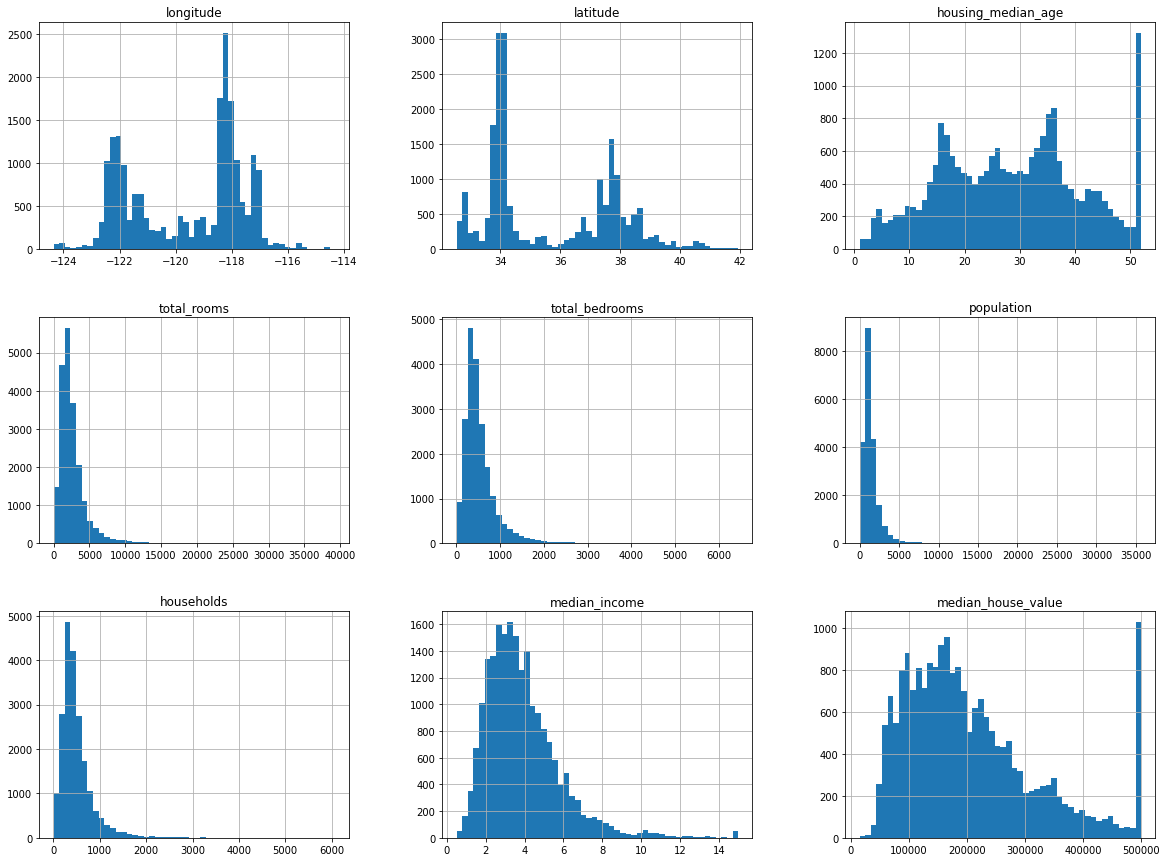

In [8]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

---

# 4. Split dos dados

- Gerando uma sequência de índices aleatórios das linhas de 'data' com `random` e `permutation` do numpy 
> shuffled_indices = np.random.permutation(len(data))

- Calculando o tamanho do conjunto de teste. Isso é feito multiplicando o número de linhas em 'data' pela proporção test_ratio e convertendo o resultado para um número inteiro usando a função `int()`.
> test_set_size = int(len(data) * test_ratio)

- Nessas duas linhas, os índices misturados aleatoriamente são divididos em dois conjuntos: um conjunto de índices para o conjunto de teste e outro conjunto de índices para o conjunto de treinamento. O tamanho do conjunto de teste é definido pela variável test_set_size.
> test_indices = shuffled_indices[:test_set_size]  
> train_indices = shuffled_indices[test_set_size:]

- É retornada uma tupla contendo dois DataFrames: o conjunto de treinamento e o conjunto de teste.
> return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
def split_train_test(data, test_ratio, random_state=None):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2, random_state=42)

In [11]:
len(train_set), len(test_set)

(16512, 4128)

---

## 4.1. No caso de dados que serão atualizados

- Essa função abaixo é uma implementação da divisão de conjuntos de treinamento e teste baseado em IDs;


- É uma técnica comum de ML para avaliar o desempenho do modelo em dados não vistos;


- É especialmente adequada para dados que serão atualizados, pois usa uma função de hash para verificar se cada ID pertence ou não ao conjunto de teste;


- Usando uma função de hash, a função pode verificar rapidamente se um ID já foi atribuído ao conjunto de teste, mesmo que o conjunto de dados tenha sido atualizado;


- Uma split baseado em amostragem aleatória para dividir os dados em conjuntos de treinamento e teste iria recriar os conjuntos de treinamento e teste toda vez que os dados fossem atualizados (ineficiente);


- Usando uma função de hash, é possível garantir que os conjuntos de treinamento e teste permaneçam os mesmos, a menos que haja uma alteração nos IDs dos dados.

In [12]:
import hashlib


def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio


def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

- Utilizando o índice da linha como ID;


- Verificando se cada ID pertence ou não ao conjunto de teste, usando uma função de hash, e dividindo o conjunto de dados em conjuntos de treinamento e teste.

> train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
housing_with_id = housing.reset_index()  # adiciona uma coluna ‘index`
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

- Criando uma nova coluna "id" no conjunto de dados "housing_with_id" e preenchendo cada linha com o ID exclusivo calculado a partir da longitude e latitude;  

> housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

OBS: ao utilizar o índice como ID exclusivo, pode ocorrer das linhas existentes serem alteradas, podendo haver sobreposição entre os identificadores antigos e novos, o que pode afetar a divisão entre conjuntos de treinamento e teste, por isso foi criado abaixo um identificador exclusivo mais estável, utilizando os dados de latitude e longitude.

In [14]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [15]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


---

## 4.2. Split dos dados com 'train_test_split' do sklearn

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [17]:
print(f'Dados de treino: {train_set.shape}')
print(f'Dados de teste: {test_set.shape}')

Dados de treino: (16512, 10)
Dados de teste: (4128, 10)


---

# 5. EDA

- A renda média é um atributo importante para estimar o preço dos prédios;


- Por isso, é importante garantir que o conjunto de testes seja representativo das várias categorias de rendimentos em todo o conjunto de dados.

<AxesSubplot: >

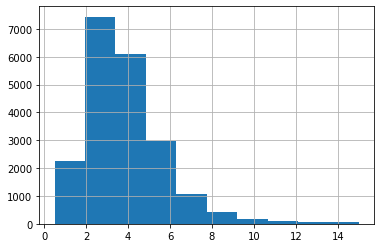

In [18]:
housing['median_income'].hist()

Transformando a renda em categorias.

In [19]:
# Tem outras funções que fazem isso como o KBinsDiscretizer (discretização de uma feature contínua)

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

Histograma das categorias de renda.

<AxesSubplot: >

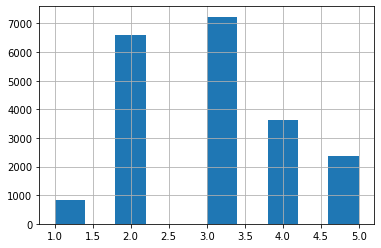

In [20]:
housing['income_cat'].hist()

Amostragem estratificada com base na categoria da renda.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Analisando as proporções da categoria de renda no conjunto de testes.

In [22]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

Comparação de viés de amostragem estratificada versus amostragem aleatória.

In [23]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    'Overall': income_cat_proportions(housing),
    'Stratified': income_cat_proportions(strat_test_set),
    'Random': income_cat_proportions(test_set),
}).sort_index()
compare_props['Rand. %error'] = 100 * \
    compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * \
    compare_props['Stratified'] / compare_props['Overall'] - 100

In [24]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.042393,6.447689,0.364964
2,0.318847,0.318798,0.307413,-3.586081,-0.015195
3,0.350581,0.350533,0.345203,-1.533997,-0.013820
4,0.176308,0.176357,0.184109,4.424292,0.027480
5,0.114438,0.114341,0.120882,5.630821,-0.084674


Removendo o 'income_cat' para voltar aos dados originais.

In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [26]:
housing = strat_train_set.copy() # Dataset de treino

Diagrama de dispersão geográfica dos dados.

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

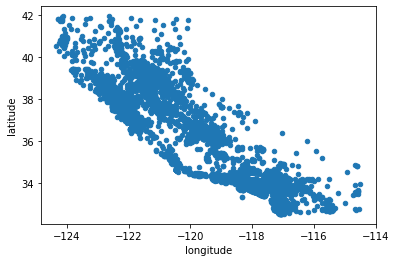

In [27]:
housing.plot(kind='scatter', x='longitude', y='latitude')

- Definindo alpha como 0.1;


- Isso facilita a visualização dos locais onde existe uma alta densidade de pontos de dados;


- Visualização destacando áreas de alta densidade:

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

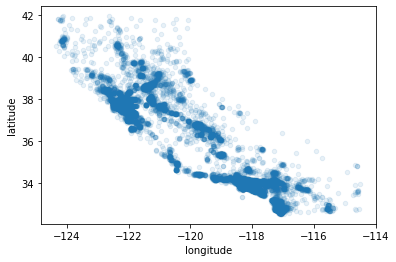

In [28]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

- Verificando os preços das casas na Califórnia;  


- s: população do bairro;  


- c: representa o preço (cor);  


- É possível notar que os preços das casas do setor imobiliário estão muito relacionados à localização e à densidade populacional.

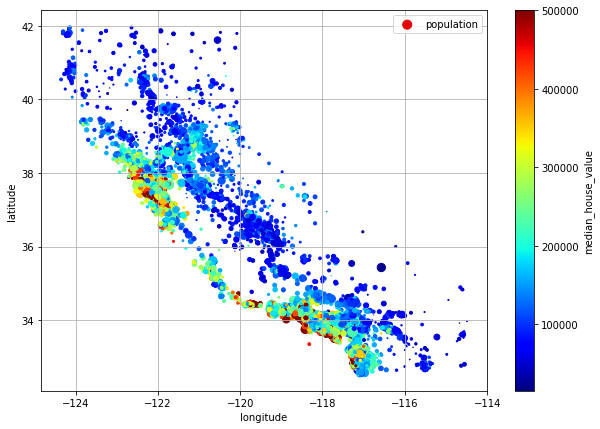

In [29]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
             s=housing['population'] / 100, label='population',
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Verificando a correlação padrão (_r de Pearson_) das colunas

In [30]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [31]:
corr_matrix = housing_num.corr(method='pearson')

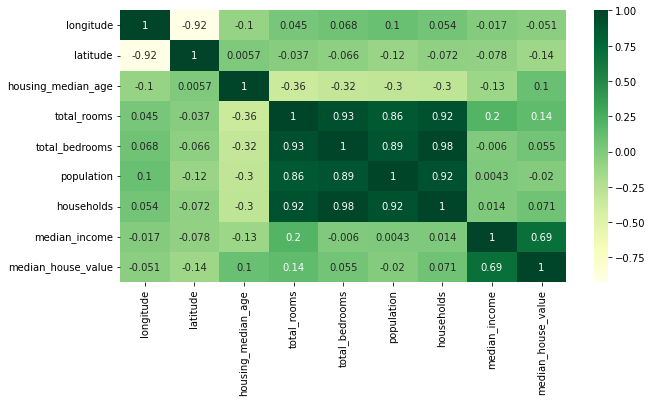

In [32]:
corr_matrix = housing_num.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='YlGn', ax=ax)
plt.show()

- Verificando o quanto cada atributo se relaciona com o valor médio da habitação;  


- É possível ver que a renda média possui correlação com o valor médio da habitação.

In [33]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Verificando a correlação com alguns atributos de interesse:

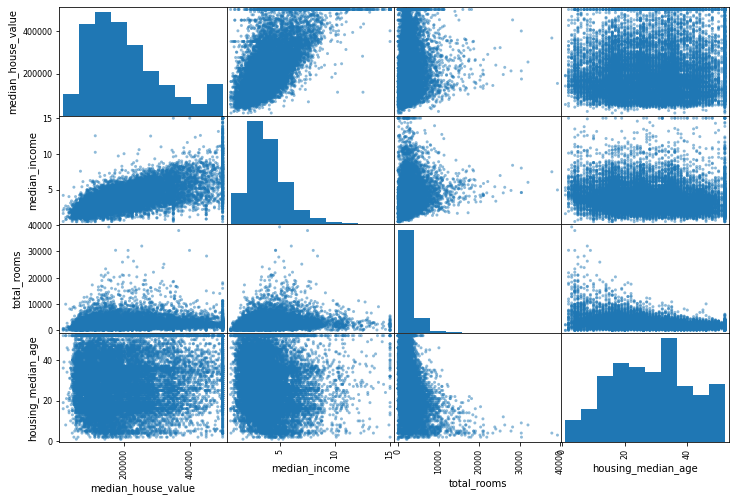

In [34]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms',
              'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

- Percebe-se que o atributo mais promissor para prever o valor médio da habitação é a renda média;  


- Abaixo é possível ver a dispersão de correlação:

     - Estão fortemente correlacionadas e com a tendência ascendente;
     - Os pontos não estão muito dispersos;
     - As linhas horizontais representam o limite de preços que foi arrendondado

<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

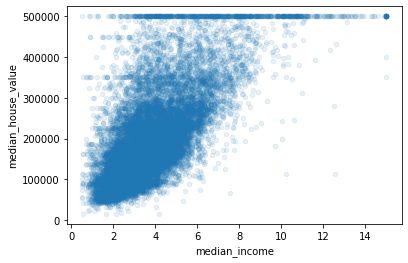

In [35]:
housing.plot(kind='scatter', x='median_income',
             y='median_house_value', alpha=0.1)

---

# 6. Features engineering

Criando a coluna de número de cômodos por domicílio.
> rooms_per_household

In [36]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']

Criando a coluna de quartos por cômodos.
> bedrooms_per_room

In [37]:
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']

Criando a coluna população por domicílio.
> population_per_household

In [38]:
housing['population_per_household'] = housing['population'] / housing['households']

Verificando a correlação com as novas colunas.

In [39]:
housing_num = housing.drop('ocean_proximity', axis=1) # Apenas a parte numérica dos dados

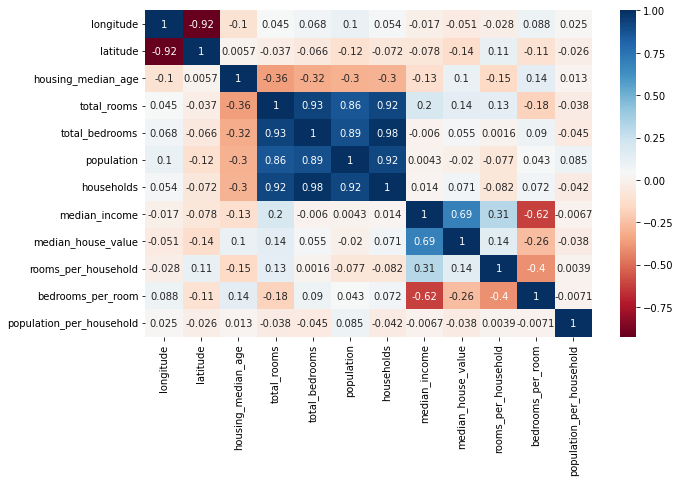

In [40]:
corr_matrix = housing_num.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', ax=ax)
plt.show()

In [41]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

Observações:

- Quartos por cômodos ('bedrooms_per_room') está muito mais correlacionado com o valor médio da habitação('median_house_value') do que com o total_rooms ou total_bedrooms;


- Aparentemente, habitações com uma baixa relação quarto/cômodo ('bedrooms_per_room') tendem a ser mais caras;


- O número de cômodos por família ('rooms_per_household') também é mais informativo do que o número total de cômodos em um bairro (quanto maiores as habitações, mais caras elas serão).

---

# 7. Separando features e target do treino

Separando os dados de treino em `housing` (features) e `housing_labels` (label).

In [42]:
housing = strat_train_set.drop('median_house_value', axis=1)  # features

housing_labels = strat_train_set['median_house_value'].copy()  # label

In [43]:
housing_pipeline = housing.copy() # Salvando para utilizar na pipeline para testar

---

# 8. Tratamento dos dados

In [44]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [45]:
housing['total_bedrooms'].isna().sum()

168

---

## 8.1. Opções para tratar os dados nulos:

Opção 1
- Livrar-se dos dados nulos correspondentes
> housing.dropna(subset=["total_bedrooms"])


Opção 2
- Livrar-se de todo o atributo/coluna
> housing.drop("total_bedrooms", axis=1)

Opção 3
- Definir valores para preencher os valores nulos (zero, a média, mediana, etc.)
> median = housing["total_bedrooms"].median()  
> housing["total_bedrooms"].fillna(median, inplace=True)

Opção 4

- Utilizando o `SimpleImputer` do Scikit-learn:  

     1. Importando e instanciando
    > from sklearn.impute import SimpleImputer  
    > imputer = SimpleImputer(strategy='median')
    
     2. Fazer uma cópia dos dados e remover os atributos categóricos
    > housing_numb = housing.drop('ocean_proximity', axis=1)
    
     3. Aplicar aos dados de treinamento usando o método .fit()
    > imputer.fit(housing_numb)
    
     4. Criando o conjunto de treinamento:
    > X = imputer.transform(housing_numb)
    
     5. Transformando a array do Numpy em Dataframes: 
    > housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [46]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [47]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [48]:
imputer.strategy

'median'

In [49]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [50]:
X = imputer.transform(housing_num)

In [52]:
housing_tr = pd.DataFrame(
    X, columns=housing_num.columns, index=housing_num.index)

In [53]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


---

## 8.2. Transformação de dados categóricos

Transformação dos dados categóricos de textos para números com o `one-hot encoding` do Scikit-learn.

In [54]:
housing[['ocean_proximity']].value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
dtype: int64

In [55]:
housing_cat = housing[['ocean_proximity']]

In [56]:
# importando e instanciando

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

In [57]:
# aplicando o one-hot encoding

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [58]:
# convertendo para um array do Numpy

housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [59]:
# verificando categorias

cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [60]:
# Voltar para os originais

# cat_encoder.inverse_transform(housing_cat_1hot)

---

# 9. Personalizando transformadores

Criando um transformador personalizado para adicionar novas colunas.

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['population_per_household'] = X['population'] / X['households']

        if self.add_bedrooms_per_room:
            X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
        
        return X

In [62]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
attr_adder.transform(housing_pipeline) # Testando

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,3.211799,1.524178,0.335742
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5.504202,1.865546,0.180153
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,5.334975,2.768473,0.200369
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,5.351282,2.365385,0.203881
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3.725256,1.631399,0.277371
...,...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN,4.277247,1.793499,0.266875
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND,5.535714,2.667293,0.201019
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN,5.157895,3.702632,0.197704
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN,4.511933,2.058473,0.230891


In [63]:
# from sklearn.base import BaseEstimator, TransformerMixin

# # índices das colunas
# rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


# class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

#     def __init__(self, add_bedrooms_per_room=True):
#         self.add_bedrooms_per_room = add_bedrooms_per_room

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
#         # rooms_per_household = X['rooms'] / X['household']
#         population_per_household = X[:, population_ix] / X[:, households_ix]

#         if self.add_bedrooms_per_room:
#             bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]

#             return np.c_[X, rooms_per_household, population_per_household,
#                          bedrooms_per_room]

#         else:
#             return np.c_[X, rooms_per_household, population_per_household]


# attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

# housing_extra_attribs = attr_adder.transform(housing.values)

In [64]:
# col_names = "total_rooms", "total_bedrooms", "population", "households"
# rooms_ix, bedrooms_ix, population_ix, households_ix = [
#     housing.columns.get_loc(c) for c in col_names]  # índices das colunas

In [65]:
# housing_extra_attribs = pd.DataFrame(
#     housing_extra_attribs,
#     columns=list(housing.columns) +
#     ["rooms_per_household", "population_per_household"],
#     index=housing.index)
# housing_extra_attribs.head()

---

## 9.1. Pipelines para escalonamento dos dados

Usando a pipeline para transformar os dados numéricos.

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline de dados numéricos

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median').set_output(transform='pandas')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler().set_output(transform='pandas')),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [67]:
housing_num_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,-0.866027,-0.330204,1.846624
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.024550,-0.253616,-0.508121
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,-0.041193,-0.051041,-0.202155
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,-0.034858,-0.141475,-0.149006
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,-0.666554,-0.306148,0.963208
...,...,...,...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041,-0.452111,-0.269780,0.804368
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630,0.036792,-0.073741,-0.192328
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049,-0.109987,0.158542,-0.242492
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396,-0.360937,-0.210332,0.259775


In [68]:
from sklearn.compose import ColumnTransformer 

# Juntando as pipelines numérica e categórica em outra pipeline 'full_pipeline'

num_attribs = list(housing_num.columns) # Informando as colunas numéricas para poder aplicar as transformações
cat_attribs = ['ocean_proximity'] # Separando o nome da coluna categórica para poder aplicar a transformação


# Criando a pipeline das pipelines
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse_output=False), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [69]:
pd.DataFrame(housing_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,-0.866027,-0.330204,1.846624,0.0,0.0,0.0,1.0,0.0
1,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,0.024550,-0.253616,-0.508121,1.0,0.0,0.0,0.0,0.0
2,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,-0.041193,-0.051041,-0.202155,0.0,1.0,0.0,0.0,0.0
3,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,-0.034858,-0.141475,-0.149006,0.0,1.0,0.0,0.0,0.0
4,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,-0.666554,-0.306148,0.963208,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041,-0.452111,-0.269780,0.804368,1.0,0.0,0.0,0.0,0.0
16508,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630,0.036792,-0.073741,-0.192328,0.0,1.0,0.0,0.0,0.0
16509,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049,-0.109987,0.158542,-0.242492,0.0,0.0,0.0,0.0,1.0
16510,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396,-0.360937,-0.210332,0.259775,1.0,0.0,0.0,0.0,0.0


---

# 10. Treinamento do modelo e CV

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

**OBS**: as avaliações estão ocorrendo no conjunto de treinamento.

X_train = housing_prepared  
y_train = housing_labels  
y_pred = housing_predictions

In [71]:
# Instanciando o modelo

lin_reg = LinearRegression()

In [72]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [73]:
# testando o modelo em algumas instâncias

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]


In [74]:
# RMSE

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67769.12117461127

In [75]:
print(f'Erro de margem: US$ {np.round(lin_rmse, 2)}')

Erro de margem: US$ 67769.12


OBS: a média de casa dos bairros varia de 120 mil a 265 mil. O erro está muito alto.

In [76]:
# Instanciando o modelo

tree_reg = DecisionTreeRegressor()

In [77]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [78]:
# O modelo é muito complexo para o problema e decorou os dados de treino (overfitting)
# Poderiamos ter controlado isso com o parâmetro max_depth no DecisionTreeRegressor

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [79]:
from sklearn.model_selection import cross_val_score

In [80]:
# Com árvore de decisão - OBS: sobreajustado

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [68136.6179887  69171.58872402 68692.69990876 73666.59406627
 69321.08338991 71520.59377396 72887.04673171 72135.81486578
 68973.48284017 70400.47316756]
Mean: 70490.59954568517
Standard deviation: 1838.1653242701218


In [81]:
# Com regressão linear

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69717.57852026 66650.26617871 66488.43193213 70393.90872693
 66837.93229332 68220.31091521 66880.08269544 69707.92372119
 67149.90434383 67802.47918508]
Mean: 67984.88185121075
Standard deviation: 1382.643929279732


In [82]:
# Com Random Forest

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18500.845182815105

In [83]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [48762.28825918 49969.19049146 47573.54522961 50546.87486609
 48864.10555209 49823.40502798 50329.34328877 51257.57472672
 49940.74542084 49433.48950508]
Mean: 49650.05623678271
Standard deviation: 991.5077659326503


In [84]:
# Com SVM

from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

110578.44384464293

---

# 11. Otimização de Hiperparâmetros

## 11. 1. GridSearchCV

Vai testar todas as combinações.

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # avaliar as 12 (3×4) combinações de hiperparâmetro
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    
    # avaliar as 6 (2×3) combinações com bootstrap como False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# treinando com cv= 5 folds, isso é um total de (12+6)*5= 90 rodadas de treinamento
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [86]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [87]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [88]:
# Combinações dos hiperparâmetros testados

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64786.429109613535 {'max_features': 2, 'n_estimators': 3}
55008.34047709832 {'max_features': 2, 'n_estimators': 10}
52544.90894239278 {'max_features': 2, 'n_estimators': 30}
59558.696221842 {'max_features': 4, 'n_estimators': 3}
52220.41086094711 {'max_features': 4, 'n_estimators': 10}
49760.96196931739 {'max_features': 4, 'n_estimators': 30}
57745.70282885063 {'max_features': 6, 'n_estimators': 3}
51281.41637335224 {'max_features': 6, 'n_estimators': 10}
49489.665429000735 {'max_features': 6, 'n_estimators': 30}
58586.09715593945 {'max_features': 8, 'n_estimators': 3}
51693.362593655154 {'max_features': 8, 'n_estimators': 10}
49622.44445561202 {'max_features': 8, 'n_estimators': 30}
62173.15215653825 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53982.55112569407 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59736.219867952765 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52944.7419651652 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

---

## 11.2. Randomized Search

Testa combinações aleatórias.

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f449df8ec20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f449df8f610>},
                   random_state=42, scoring='neg_mean_squared_error')

In [91]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

48817.07237111398 {'max_features': 7, 'n_estimators': 180}
51124.368841786425 {'max_features': 5, 'n_estimators': 15}
50295.19999459879 {'max_features': 3, 'n_estimators': 72}
50497.3939287014 {'max_features': 5, 'n_estimators': 21}
48905.78551167292 {'max_features': 7, 'n_estimators': 122}
50282.233508532976 {'max_features': 3, 'n_estimators': 75}
50039.318321106344 {'max_features': 3, 'n_estimators': 88}
49118.457451549664 {'max_features': 5, 'n_estimators': 100}
49892.18228479081 {'max_features': 3, 'n_estimators': 150}
65003.603277711685 {'max_features': 5, 'n_estimators': 2}


---

## 11.3. Analisando os melhores modelos e seus erros

In [92]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.12728791e-02, 6.54321372e-02, 4.32129653e-02, 1.81524411e-02,
       1.64740195e-02, 1.75839475e-02, 1.62698618e-02, 3.25874013e-01,
       4.77885564e-02, 1.13429502e-01, 9.52943597e-02, 8.01398025e-03,
       1.54410499e-01, 9.13375828e-05, 2.33100242e-03, 4.36849765e-03])

In [93]:
# Importância das colunas

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # edição antiga
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32587401331044474, 'median_income'),
 (0.154410498776203, 'INLAND'),
 (0.11342950246577534, 'pop_per_hhold'),
 (0.0952943597267449, 'bedrooms_per_room'),
 (0.07127287911034556, 'longitude'),
 (0.06543213717751256, 'latitude'),
 (0.04778855639185918, 'rooms_per_hhold'),
 (0.04321296526058239, 'housing_median_age'),
 (0.018152441064856625, 'total_rooms'),
 (0.017583947470274367, 'population'),
 (0.01647401952142944, 'total_bedrooms'),
 (0.01626986183181417, 'households'),
 (0.008013980247479598, '<1H OCEAN'),
 (0.004368497646219832, 'NEAR OCEAN'),
 (0.0023310024156462726, 'NEAR BAY'),
 (9.133758281200087e-05, 'ISLAND')]

---

# 12. Avaliação no conjunto de teste

In [94]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [95]:
# RMSE

rmse = np.round(final_rmse,2)
rmse

50522.23

In [96]:
# Média do teste

mean_house_values = np.round(np.mean(y_test),2)
mean_house_values

208945.01

In [97]:
# Porcentagem do RMSE da média do teste

perc_rmse = (rmse / mean_house_values) * 100
perc_rmse

24.179677705631736

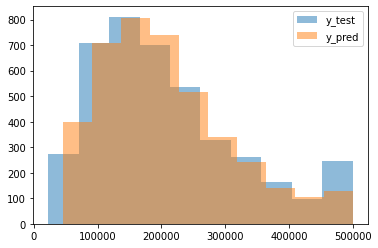

In [98]:
# Distribuição do y_test e y_pred

plt.hist(y_test, alpha= 0.5, label='y_test')
plt.hist(final_predictions, alpha= 0.5, label='y_pred')
plt.legend()
plt.show()